### Third task

Мы видим, что модель некоторые точки неверно детектирует на скачанных нами лицах и мы хотим отправить эти данные на разметку человеком. Для этого мы хотим в инструмент для разметки данных загрузить изображения и предсказания модели для последующего исправления людьми. Соответственно в этом задании нужно:
* завести если нет аккаунт на сервисе supervisely
* почитать документацию и разобраться с SDK/Python-API для supervisely
* написать код для загрузки данных в supervisely (в этом же jupyter-notebook)
* загрузить 5-10 изображений и предсказаний модели в supervisely и вставить скриншот с работающего сервиса
* описать алгоритм доразметки, что конкретно и как вам кажется нужно разметить
* замерьте скорость разметки и оцените время разметки с нуля и время доразметки результатов работы модели

In [1]:
import os
import json

import supervisely as sly
from supervisely.geometry.point import Point
import numpy as np
import pandas as pd


api = sly.Api.from_env()

In [2]:
def string_to_image(image_str):
    image = np.fromiter(map(float, image_str.split()), dtype=np.uint8)
    image = image.reshape(96, 96)
    return image

In [7]:
training_csv = "kaggle/training.csv"
df = pd.read_csv(training_csv)

with open("worst_images.json") as fh:
    worst_images = json.load(fh)

images_np = {}
images_landmarks = {}
for idx, landmarks in worst_images.items():
    images_np[idx] = string_to_image(df.loc[int(idx)]["Image"])
    images_landmarks[idx] = landmarks["landmarks"]

In [10]:
workspace_id = 119403
project_name = "Face Annotation Project"
dataset_name = "Faces Dataset"

In [22]:
project = api.project.create(workspace_id, project_name, change_name_if_conflict=True)
dataset = api.dataset.create(project.id, dataset_name, change_name_if_conflict=True)

landmark_class = sly.ObjClass("landmark", sly.Point)
meta = sly.ProjectMeta(obj_classes=[landmark_class])
api.project.update_meta(project.id, meta.to_json())

image_infos = api.image.upload_nps(
    dataset.id,
    list(map(lambda x: f"{x}.jpg", list(images_np))),
    list(images_np.values())
)

In [23]:
for image_info in image_infos:
    id_ = image_info.name.split(".jpg")[0]
    predicted_points = images_landmarks[id_]
    points = [sly.Point(y, x) for x, y in predicted_points]
    figure_objects = [sly.Label(point, landmark_class) for point in points]
    
    annotation = sly.Annotation(img_size=(image_info.height, image_info.width), labels=figure_objects)
    api.annotation.upload_ann(image_info.id, annotation)

### Results

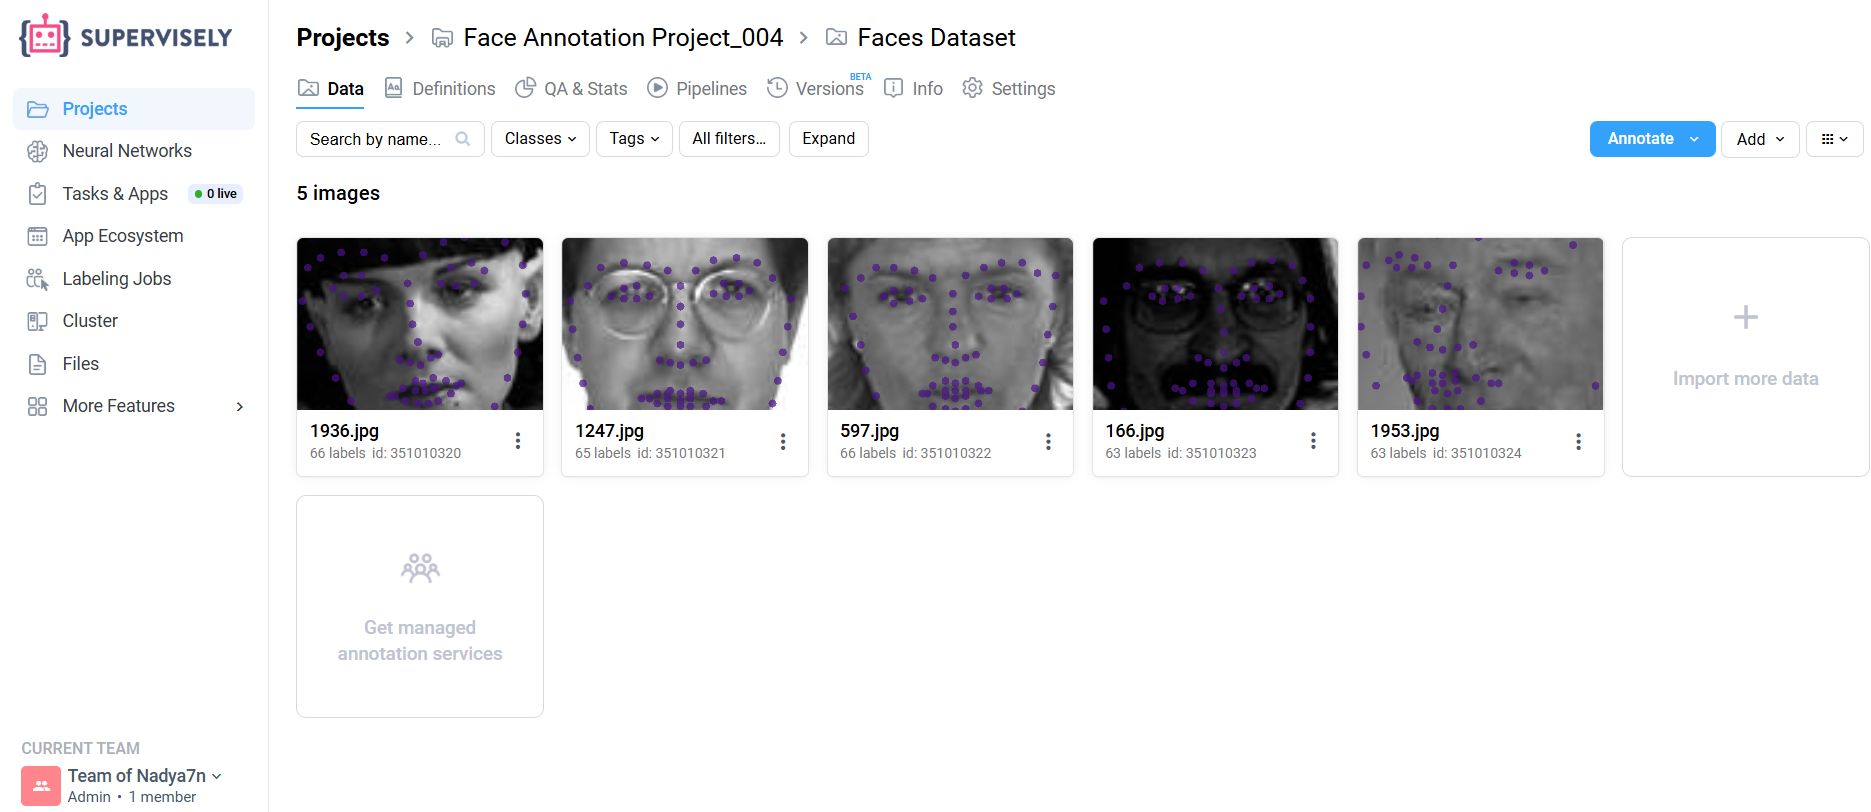

### Описание алгоритма доразметки
#### Первый вариант - точки
1. Я бы взяла те 15 фич из кагл датасета
2. Вручную поставить эти точки
3. Почему именно эти фичи, потому что они являются наиболее показательными как опознавательные точки для лиц, плюс их не так много, чем переносить 68 точек
    * left_eye_center (1)
    * right_eye_center (2)
    * left_eye_inner_corner (3)
    * left_eye_outer_corner (4)
    * right_eye_inner_corner (5)
    * right_eye_outer_corner (6)
    * left_eyebrow_inner_end (7)
    * left_eyebrow_outer_end (8)
    * right_eyebrow_inner_end (9)
    * right_eyebrow_outer_end (10) 
    * nose_tip (11)
    * mouth_left_corner (12)
    * mouth_right_corner (13)
    * mouth_center_top_lip (14)
    * mouth_center_bottom_lip (15)

4. Для наглядности внизу пример, где находятся эти ключевые точки
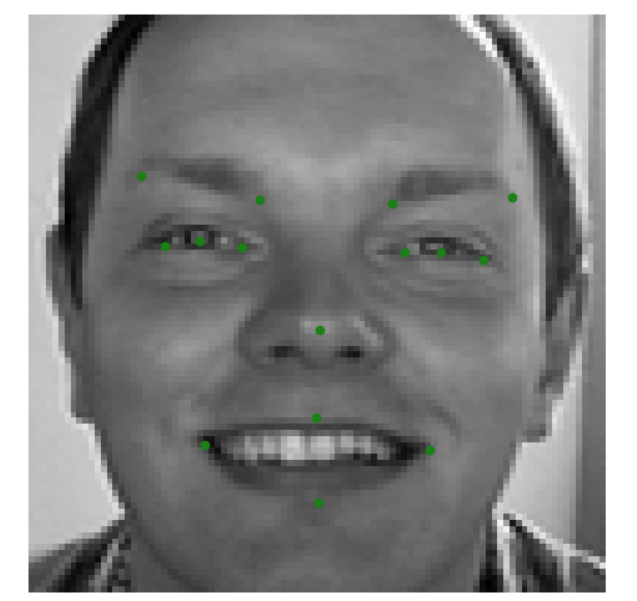

#### Второй вариант - линии и многогранники
1. Обвести контуры лица и основные характерные для лица черты многогранниками

Внизу пример для наглядности

### Оценка времени разметки с нуля и доразметки после обучения модели

#### Разметка с нуля
t = 

#### Доразметка после обучения модели
t = 